In [1]:
import os
import pandas as pd
import configparser
import json

import utils_polyps as up
import feature_matching as fm
import image_utils as iu
import training_dataset as td
from biigle import Api

Chemin vers fichier de configuration et nom du volume traité

In [2]:
config_path = "D:\ARDECO\config.ini"
volume = 'A3S3'

In [3]:
config = configparser.ConfigParser()
config.read(config_path)

print("Config : ")
print(dict(config.items(volume)))

api = Api(config['DEFAULT']['email'], config['DEFAULT']['token'])

img_ref_polyps  = json.loads(config.get(volume,"img_ref_polyps"))
labels_name_ref = json.loads(config.get(volume,"labels_name_ref"))
labels_name_classification = json.loads(config.get(volume,"labels_name_classification"))
labels_name_all = json.loads(config.get(volume,"labels_name_ref"))
labels_name_all.extend(labels_name_classification)

train_path = os.path.join(config[volume]['output_path'], 'train') 
temp_path = os.path.join(config[volume]['output_path'],'temp')

for path in [train_path, temp_path]: # Create if do not exist
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)
    
output_h_matrix_path = os.path.join(config[volume]['output_path'], 'h_matrixs.txt')
polyps_positions_path = os.path.join(config[volume]['output_path'], 'polyps_coords.csv')
polyp_ref_path = os.path.join(config[volume]['output_path'], 'polyp_ref.csv')

annotations = pd.read_csv(config[volume]['report_path'])

Config : 
{'email': 'marin.marcillat@ifremer.fr', 'token': '9HTXoupsKlj3YyqH5vKCKYBvG1iwzbZV', 'images_path': 'W:\\images\\ARDECO23\\A3_PRES_S3', 'report_path': 'D:\\ARDECO\\A3_PRES_S3\\118-a3-pres-s3.csv', 'output_path': 'D:\\ARDECO\\A3_PRES_S3', 'img_ref_pos': 'A3_PRES_S3-00001.jpeg', 'img_ref_polyps': '["A3_PRES_S3-00001.jpeg"]', 'labels_name_ref': '["Madrepora"]', 'labels_name_classification': '["Madrepora_extended", "Madrepora_retracted", "Madrepora_shy"]', 'label_tree_id': '64', 'volume_id': '118'}


## Préparation (matrices homographiques, convertir les coordonnées)

Obtenir les matrices de transformation homographiques par rapport à l'image de référence image_ref_pos

In [4]:
print("Get homography matrixs...")
fm.get_h_matrixs(config[volume]['images_path'], config[volume]['img_ref_pos'], output_h_matrix_path)

Get homography matrixs...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20301/20301 [6:08:25<00:00,  1.09s/it]


Avec le rapport Biigle, extraire les polypes et convertir leurs coordonnées

In [4]:
h_matrixs = pd.read_csv(output_h_matrix_path) # Charger les matrices homographiques déjà calculées

print("Convert polyps coordinates...")
polyps_positions = up.get_polyps_coords(config[volume]['images_path'], annotations, h_matrixs, labels_name_all, config[volume]['output_path'])

Convert polyps coordinates...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16027/16027 [00:04<00:00, 3245.51it/s]


In [13]:
# Charger les positions des polypes
polyps_positions = pd.read_csv(polyps_positions_path)

In [5]:
display(polyps_positions.head())  # Show some polyps

,filename,label,x,y,w,h
0,A3_PRES_S3-00001.jpeg,Madrepora,1003,4,116,60
1,A3_PRES_S3-00001.jpeg,Madrepora,609,226,89,81
2,A3_PRES_S3-00001.jpeg,Madrepora,1303,837,77,88
3,A3_PRES_S3-00001.jpeg,Madrepora,1014,-13,94,94
4,A3_PRES_S3-00001.jpeg,Madrepora,611,224,84,84


## Obtenir les anotations de référence

Maintenant, on extrait les coordonnées des polypes de référence de une ou plusieurs images. Eventuellement, affiner les bounding box en utilisant les autres annotations

In [6]:
print("Get reference polyps...")
polyp_ref = up.get_ref_polyps(polyps_positions, img_ref_polyps, labels_name_ref, config[volume]['output_path'])

Get reference polyps...


20it [00:00, ?it/s]


In [6]:
polyp_ref = pd.read_csv(polyp_ref_path)

In [7]:
display(polyp_ref.head(20))

,x,y,w,h
0,936.0,488.0,108.0,108.0
1,1100.0,323.0,84.0,84.0
2,989.0,157.0,62.0,62.0
3,951.0,208.0,96.0,96.0
4,1065.0,205.0,74.0,74.0
5,1145.0,161.0,70.0,70.0
6,1302.0,270.0,56.0,56.0
7,1315.0,326.0,52.0,52.0
8,1219.0,429.0,70.0,70.0
9,1056.0,484.0,72.0,72.0


Plotter les polypes de référence pour vérification

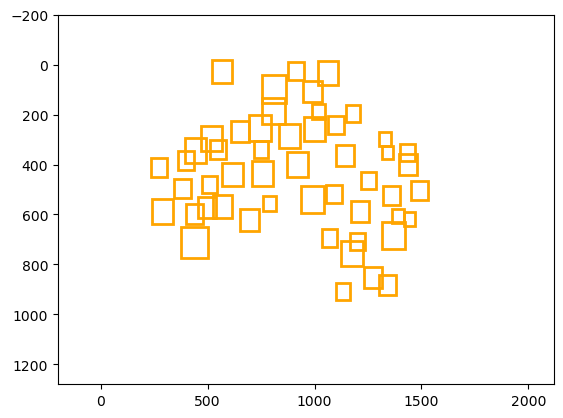

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
ax.axis([-200, 1920 +200, -200, 1080+200])
ax.invert_yaxis()

for index, row in polyp_ref.iterrows():
    x, y, w, h = row['x'], row['y'], row['w'], row['h']
    if row['w'] < 0:
        ax.add_patch(Rectangle((x, y), w, h,
                       edgecolor='blue',
                       facecolor='none',
                       lw=2))
    else:
        ax.add_patch(Rectangle((x, y), w, h,
                               edgecolor='orange',
                               facecolor='none',
                               lw=2))
plt.show()

## Plotter les annotations de référence sur toutes les images Biigle

In [10]:
# Charger les polypes de référence
polyp_ref = pd.read_csv(polyp_ref_path)

Découper les polypes de référence dans toute les images Biigle, selon une certaine fréquence.

In [14]:
draw_frequence = 1/100

up.draw_polyps_from_ref(config[volume]['images_path'], draw_frequence, h_matrixs, polyp_ref, labels_name_ref[0], temp_path, api, config[volume]['label_tree_id'], config[volume]['volume_id'])

Creating label index for API
Creating image index for API
Done !


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [02:25<00:00,  1.40it/s]


## Creation d'un jeu d'entrainement

Couper et classer les images selon les emprises des annotations.

In [4]:
print("Cropping and classing images....")
td.crop_all_images_training(config[volume]['images_path'], annotations, labels_name_classification, train_path)

Cropping and classing images....


 ... (more hidden) ...
